In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Problem Statement
## <b>In this problem you have to predict the age of a person with the help of their image

#### Import libraries

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import shutil

import tensorflow as tf
from tensorflow import keras

from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential, Model
from keras.layers import Flatten, Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input
from keras.activations import  relu

from tensorflow.keras.optimizers import SGD, Adam, RMSprop

from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K

In [3]:
from keras.preprocessing.image import load_img, array_to_img, img_to_array

In [4]:
from PIL import Image

In [5]:
from tqdm import tqdm
BASE_DIR = '../input/overnight-hackathon/Train_Images/Train_Images'
image_paths = []
age_labels = []
for filename in tqdm(os.listdir(BASE_DIR)):
    image_path = os.path.join(BASE_DIR, filename)
    age = int((filename.split('_'))[-1].split('.')[0])
    image_paths.append(image_path)
    age_labels.append(age)
    

100%|██████████| 29497/29497 [00:00<00:00, 357134.90it/s]


In [6]:
df = pd.DataFrame()
df['img_file'], df['age']= image_paths, age_labels
df.head()

,img_file,age
0,../input/overnight-hackathon/Train_Images/Trai...,15
1,../input/overnight-hackathon/Train_Images/Trai...,18
2,../input/overnight-hackathon/Train_Images/Trai...,29
3,../input/overnight-hackathon/Train_Images/Trai...,33
4,../input/overnight-hackathon/Train_Images/Trai...,22


In [7]:
df.iloc[0]['img_file']

'../input/overnight-hackathon/Train_Images/Train_Images/IMG_24111_FI_F_15.png'

In [8]:
df_HI= df[df['img_file'].str.contains('HI')]
df_FI= df[df['img_file'].str.contains('FI')]

In [9]:
def extract_features(images):
    features = []
    for image in tqdm(images):
        img = load_img(image, grayscale=True)
        img = img.resize((128, 128), Image.ANTIALIAS)
        img = np.array(img)
        features.append(img)
        
    features = np.array(features)
    # ignore this step if using RGB
    features = features.reshape(len(features), 128, 128, 1)
    return features

In [10]:
X_FI = extract_features(df_FI['img_file'])

  0%|          | 0/13288 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  """
100%|██████████| 13288/13288 [01:14<00:00, 178.13it/s]


In [11]:
X_FI.shape

(13288, 128, 128, 1)

In [12]:
#remove garbage data
import gc

gc.collect()

46

In [13]:
def extract_features_HI(images):
    features = []
    for image in tqdm(images):
        img = load_img(image, grayscale=True)
        #img = img.resize((128, 128), Image.ANTIALIAS)
        img = np.array(img)
        features.append(img)
        
    features = np.array(features)
    # ignore this step if using RGB
    features = features.reshape(len(features), 200, 200, 1)
    return features

In [14]:
X_HI = extract_features_HI(df_HI['img_file'])

100%|██████████| 16209/16209 [01:25<00:00, 190.34it/s]


In [15]:
gc.collect()

69

In [16]:
X_HI.shape

(16209, 200, 200, 1)

In [17]:
y_age_HI = np.array(df_HI['age'])
y_age_FI = np.array(df_FI['age'])

In [18]:
y_age_HI.shape,y_age_HI.shape

((16209,), (16209,))

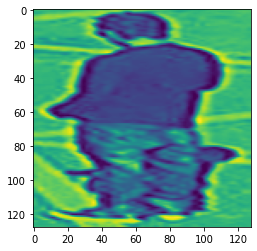

In [19]:
plt.imshow(X_FI[5])

In [20]:
idg = ImageDataGenerator(rescale=1/255.0, vertical_flip=True,rotation_range=20, validation_split=0.2)

In [28]:
# del df
# gc.collect()

5118

In [29]:
# del df_HI
# gc.collect()

23

In [ ]:
# del df_FI
# gc.collect()

## Building Model for HI

In [21]:
X_train_HI, X_val_HI, y_train_HI, y_val_HI = train_test_split(X_HI, y_age_HI, test_size=0.2, random_state=33)

In [22]:
# Data Augmentation
datagen_HI = ImageDataGenerator(
        rotation_range=30,
        horizontal_flip=True,
        fill_mode='nearest')

datagen_HI.fit(X_train_HI)

val_datagen_HI = ImageDataGenerator(
        rotation_range=30,
        horizontal_flip=True,
        fill_mode='nearest')

val_datagen_HI.fit(X_val_HI)

In [23]:
model_HI = Sequential()

# 1st Chunk
model_HI.add(Conv2D(filters=32, kernel_size=(3,3), strides=(1,1), padding='valid', activation=relu,  
                 input_shape=(200,200,1)))
model_HI.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid', ))

# 2nd Chunk
model_HI.add(Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='valid', activation=relu,))
model_HI.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid', ))

# 3rd Chunk
model_HI.add(Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='valid', activation=relu,))
model_HI.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid', ))

# 4th Chunk
model_HI.add(Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding='valid', activation=relu,))
model_HI.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid', ))

#Apply Flattening
model_HI.add(Flatten())


#model.add(Dense(1024, activation=softmax))
#
#model.add(Dense(128, activation=softmax))
model_HI.add(Dense(256, activation='relu'))
model_HI.add(Dropout(0.2))
#
model_HI.add(Dense(16, activation='relu'))

model_HI.add(Dense(1, activation='relu')) 
model_HI.summary()

2022-11-13 09:25:19.157770: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-13 09:25:19.272741: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-13 09:25:19.273612: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-13 09:25:19.275462: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 198, 198, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 99, 99, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 97, 97, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 48, 48, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 46, 46, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 21, 21, 128)       7

node zero
2022-11-13 09:25:21.790084: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-13 09:25:21.791172: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-13 09:25:21.792087: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-13 09:25:21.792964: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15401 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [24]:
from keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=7, verbose=1, mode='auto')

In [25]:
model_HI.compile(optimizer=RMSprop(),loss='mean_squared_error',metrics=['accuracy'])

In [26]:
gc.collect()

341

In [27]:
model_history_HI = model_HI.fit_generator(datagen_HI.flow(X_train_HI, y_train_HI, batch_size=32), 
                    #samples_per_epoch=len(X_train),  
                    epochs=40, 
                    validation_data=val_datagen_HI.flow(X_val_HI, y_val_HI, batch_size=32),
                    #nb_val_samples=len(X_val),
                    verbose=1,
                    callbacks=[early_stop])

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
2022-11-13 09:26:04.665605: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/40


2022-11-13 09:26:06.570624: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


406/406 [==============================] - 54s 113ms/step - loss: 19988.3340 - accuracy: 0.0467 - val_loss: 283.4178 - val_accuracy: 0.0490
Epoch 2/40
406/406 [==============================] - 45s 111ms/step - loss: 347.5276 - accuracy: 0.0440 - val_loss: 241.0771 - val_accuracy: 0.0444
Epoch 3/40
406/406 [==============================] - 44s 108ms/step - loss: 261.4777 - accuracy: 0.0325 - val_loss: 173.3455 - val_accuracy: 0.0271
Epoch 4/40
406/406 [==============================] - 45s 111ms/step - loss: 220.1534 - accuracy: 0.0261 - val_loss: 154.5938 - val_accuracy: 0.0281
Epoch 5/40
406/406 [==============================] - 45s 110ms/step - loss: 190.9018 - accuracy: 0.0231 - val_loss: 157.6150 - val_accuracy: 0.0111
Epoch 6/40
406/406 [==============================] - 46s 112ms/step - loss: 171.4565 - accuracy: 0.0316 - val_loss: 124.8135 - val_accuracy: 0.0490
Epoch 7/40
406/406 [==============================] - 45s 110ms/step - loss: 159.1926 - accuracy: 0.0463 - val_loss

In [32]:
print(model_history_HI.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


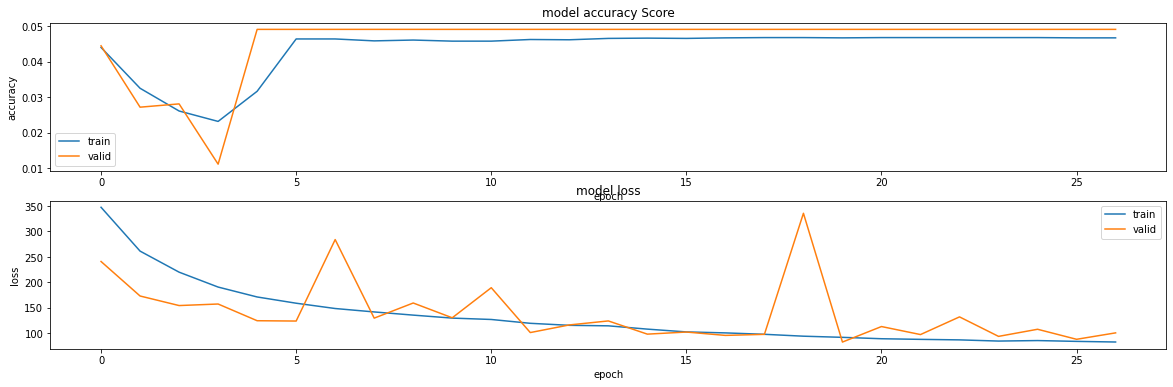

In [33]:
plt.figure(1, figsize = (20,6)) 
    
plt.subplot(211)  
plt.plot(model_history_HI.history['accuracy'][1:])  
plt.plot(model_history_HI.history['val_accuracy'][1:])  
plt.title('model accuracy Score')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 
    
plt.subplot(212)  
plt.plot(model_history_HI.history['loss'][1:])  
plt.plot(model_history_HI.history['val_loss'][1:])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 

plt.show()

In [34]:
# del model_history_HI
# gc.collect()

6413

In [35]:
history_HI = model_HI.fit(x=X_HI, y=y_age_HI, batch_size=32, epochs=30, validation_split=0.2,)


Epoch 1/30
406/406 [==============================] - 10s 22ms/step - loss: 75.9954 - accuracy: 0.0472 - val_loss: 89.1093 - val_accuracy: 0.0472
Epoch 2/30
406/406 [==============================] - 9s 23ms/step - loss: 67.9108 - accuracy: 0.0472 - val_loss: 70.4331 - val_accuracy: 0.0472
Epoch 3/30
406/406 [==============================] - 9s 21ms/step - loss: 59.9507 - accuracy: 0.0472 - val_loss: 107.6028 - val_accuracy: 0.0472
Epoch 4/30
406/406 [==============================] - 9s 23ms/step - loss: 54.7411 - accuracy: 0.0472 - val_loss: 151.2594 - val_accuracy: 0.0472
Epoch 5/30
406/406 [==============================] - 9s 23ms/step - loss: 50.7845 - accuracy: 0.0472 - val_loss: 92.2799 - val_accuracy: 0.0472
Epoch 6/30
406/406 [==============================] - 9s 23ms/step - loss: 43.0131 - accuracy: 0.0472 - val_loss: 75.1163 - val_accuracy: 0.0472
Epoch 7/30
406/406 [==============================] - 9s 22ms/step - loss: 41.8695 - accuracy: 0.0471 - val_loss: 95.1553 - val

In [ ]:
#model_HI.save("keras_HI_Model")

In [36]:
print(history_HI.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


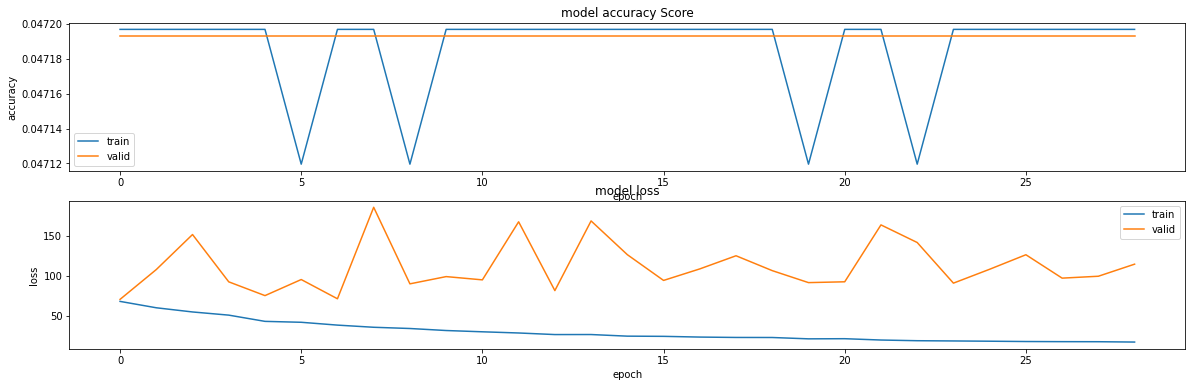

In [37]:
plt.figure(1, figsize = (20,6)) 
    
plt.subplot(211)  
plt.plot(history_HI.history['accuracy'][1:])  
plt.plot(history_HI.history['val_accuracy'][1:])  
plt.title('model accuracy Score')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 
    
plt.subplot(212)  
plt.plot(history_HI.history['loss'][1:])  
plt.plot(history_HI.history['val_loss'][1:])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 

plt.show()

In [38]:

gc.collect()

7777

In [39]:
history_HI = model_HI.fit(x=X_HI, y=y_age_HI, batch_size=32, epochs=30, validation_split=0.2, callbacks=[early_stop])

Epoch 1/30
406/406 [==============================] - 9s 22ms/step - loss: 16.4743 - accuracy: 0.0472 - val_loss: 89.3960 - val_accuracy: 0.0472
Epoch 2/30
406/406 [==============================] - 9s 21ms/step - loss: 16.6525 - accuracy: 0.0471 - val_loss: 184.2664 - val_accuracy: 0.0472
Epoch 3/30
406/406 [==============================] - 9s 21ms/step - loss: 17.3814 - accuracy: 0.0472 - val_loss: 94.3301 - val_accuracy: 0.0472
Epoch 4/30
406/406 [==============================] - 9s 22ms/step - loss: 15.6450 - accuracy: 0.0472 - val_loss: 119.4966 - val_accuracy: 0.0472
Epoch 5/30
406/406 [==============================] - 9s 23ms/step - loss: 15.3795 - accuracy: 0.0472 - val_loss: 125.9393 - val_accuracy: 0.0472
Epoch 6/30
406/406 [==============================] - 9s 21ms/step - loss: 16.0583 - accuracy: 0.0472 - val_loss: 81.0488 - val_accuracy: 0.0472
Epoch 7/30
406/406 [==============================] - 9s 21ms/step - loss: 15.9533 - accuracy: 0.0472 - val_loss: 127.6513 - va

In [40]:
print(history_HI.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


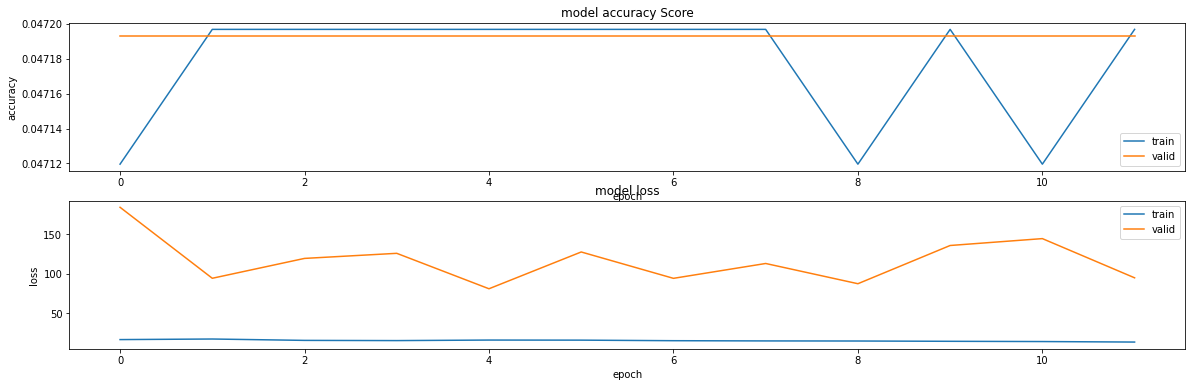

In [41]:
plt.figure(1, figsize = (20,6)) 
    
plt.subplot(211)  
plt.plot(history_HI.history['accuracy'][1:])  
plt.plot(history_HI.history['val_accuracy'][1:])  
plt.title('model accuracy Score')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 
    
plt.subplot(212)  
plt.plot(history_HI.history['loss'][1:])  
plt.plot(history_HI.history['val_loss'][1:])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 

plt.show()

In [43]:
gc.collect()

23

In [44]:
model_HI.save("keras_HI_Model")

2022-11-13 10:08:32.127302: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


## FI Model

In [54]:
X_train_FI, X_val_FI, y_train_FI, y_val_FI = train_test_split(X_FI, y_age_FI, test_size=0.2, random_state=33)

In [56]:
# Data Augmentation
datagen_FI = ImageDataGenerator(
        rotation_range=30,
        horizontal_flip=True,
        fill_mode='nearest')

datagen_FI.fit(X_train_FI)

val_datagen_FI = ImageDataGenerator(
        rotation_range=30,
        horizontal_flip=True,
        fill_mode='nearest')

val_datagen_FI.fit(X_val_FI)

In [47]:
model_FI = Sequential()

# 1st Chunk
model_FI.add(Conv2D(filters=32, kernel_size=(3,3), strides=(1,1), padding='valid', activation=relu,  
                 input_shape=(128,128,1)))
model_FI.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid', ))

# 2nd Chunk
model_FI.add(Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='valid', activation=relu,))
model_FI.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid', ))

# 3rd Chunk
model_FI.add(Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='valid', activation=relu,))
model_FI.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid', ))

# 4th Chunk
model_FI.add(Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding='valid', activation=relu,))
model_FI.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid', ))

#Apply Flattening
model_FI.add(Flatten())


#model.add(Dense(1024, activation=softmax))
#
#model.add(Dense(128, activation=softmax))
model_FI.add(Dense(256, activation='relu'))
model_FI.add(Dropout(0.2))
#
model_FI.add(Dense(16, activation='relu'))

model_FI.add(Dense(1, activation='relu')) 
model_FI.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 126, 126, 32)      320       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 28, 28, 64)        36928     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 12, 12, 128)      

In [48]:
early_stop = EarlyStopping(monitor='val_loss', patience=7, verbose=1, mode='auto')

In [49]:
model_FI.compile(optimizer=Adam(),loss='mean_squared_error',metrics=['accuracy'])

In [60]:
gc.collect()

50

In [59]:
model_history_FI = model_FI.fit_generator(datagen_FI.flow(X_train_FI, y_train_FI, batch_size=32), 
                    #samples_per_epoch=len(X_train),  
                    epochs=40, 
                    validation_data=val_datagen_FI.flow(X_val_FI, y_val_FI, batch_size=32),
                    #nb_val_samples=len(X_val),
                    verbose=1,
                    callbacks=[early_stop])

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/40
333/333 [==============================] - 17s 50ms/step - loss: 290.2381 - accuracy: 0.0000e+00 - val_loss: 198.0184 - val_accuracy: 0.0000e+00
Epoch 2/40
333/333 [==============================] - 17s 51ms/step - loss: 213.3094 - accuracy: 0.0000e+00 - val_loss: 183.7497 - val_accuracy: 0.0000e+00
Epoch 3/40
333/333 [==============================] - 16s 49ms/step - loss: 201.2801 - accuracy: 0.0000e+00 - val_loss: 178.8145 - val_accuracy: 0.0000e+00
Epoch 4/40
333/333 [==============================] - 17s 51ms/step - loss: 193.3350 - accuracy: 0.0000e+00 - val_loss: 176.5374 - val_accuracy: 0.0000e+00
Epoch 5/40
333/333 [==============================] - 16s 48ms/step - loss: 186.0485 - accuracy: 0.0000e+00 - val_loss: 166.7442 - val_accuracy: 0.0000e+00
Epoch 6/40
333/333 [==============================] - 16s 49ms/step - loss: 183.8833 - accuracy: 0.0000e+00 - val_loss: 170.2626 - val_accuracy: 0.0000e+00
Epoch 7/40
333/333 [==============================] - 17s 51ms/s

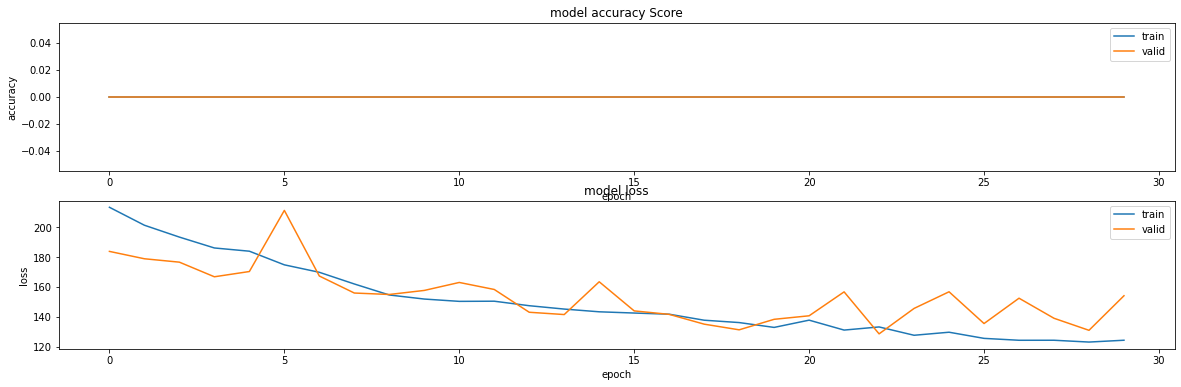

In [61]:
plt.figure(1, figsize = (20,6)) 
    
plt.subplot(211)  
plt.plot(model_history_FI.history['accuracy'][1:])  
plt.plot(model_history_FI.history['val_accuracy'][1:])  
plt.title('model accuracy Score')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 
    
plt.subplot(212)  
plt.plot(model_history_FI.history['loss'][1:])  
plt.plot(model_history_FI.history['val_loss'][1:])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 

plt.show()

In [62]:
history_FI = model_FI.fit(x=X_FI, y=y_age_FI, batch_size=32, epochs=30, validation_split=0.2, callbacks=[early_stop])

Epoch 1/30
333/333 [==============================] - 4s 12ms/step - loss: 116.4381 - accuracy: 0.0000e+00 - val_loss: 113.1443 - val_accuracy: 0.0000e+00
Epoch 2/30
333/333 [==============================] - 4s 11ms/step - loss: 98.5438 - accuracy: 0.0000e+00 - val_loss: 118.8033 - val_accuracy: 0.0000e+00
Epoch 3/30
333/333 [==============================] - 4s 11ms/step - loss: 87.2919 - accuracy: 0.0000e+00 - val_loss: 117.7800 - val_accuracy: 0.0000e+00
Epoch 4/30
333/333 [==============================] - 4s 11ms/step - loss: 73.3664 - accuracy: 0.0000e+00 - val_loss: 148.6189 - val_accuracy: 0.0000e+00
Epoch 5/30
333/333 [==============================] - 4s 11ms/step - loss: 65.9824 - accuracy: 0.0000e+00 - val_loss: 123.5711 - val_accuracy: 0.0000e+00
Epoch 6/30
333/333 [==============================] - 4s 11ms/step - loss: 54.8791 - accuracy: 0.0000e+00 - val_loss: 124.6078 - val_accuracy: 0.0000e+00
Epoch 7/30
333/333 [==============================] - 4s 12ms/step - loss: 

In [63]:
gc.collect()

8284

In [64]:
model_FI.save("keras_FI_Model")

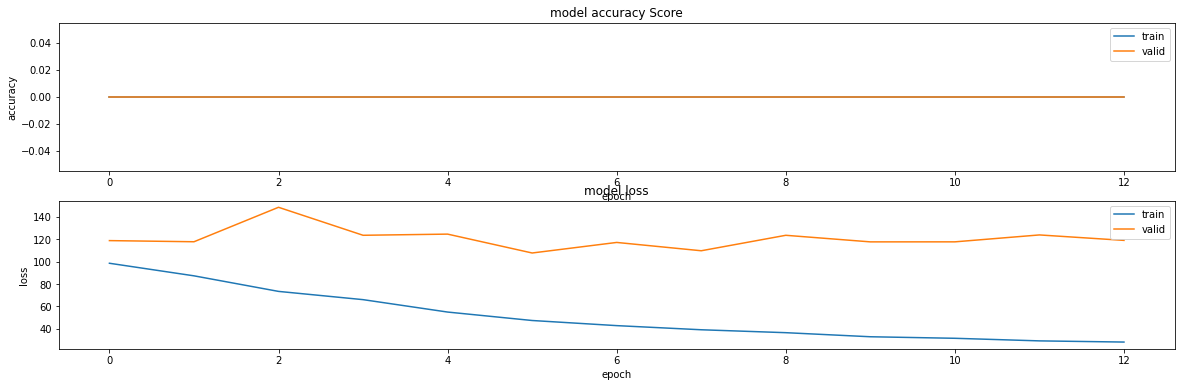

In [65]:
plt.figure(1, figsize = (20,6)) 
    
plt.subplot(211)  
plt.plot(history_FI.history['accuracy'][1:])  
plt.plot(history_FI.history['val_accuracy'][1:])  
plt.title('model accuracy Score')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 
    
plt.subplot(212)  
plt.plot(history_FI.history['loss'][1:])  
plt.plot(history_FI.history['val_loss'][1:])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 

plt.show()

## Test_Images

In [67]:
BASE_DIR = '../input/overnight-hackathon/Test_Image/Test_Image'
image_paths = []
for filename in tqdm(os.listdir(BASE_DIR)):
    image_path = os.path.join(BASE_DIR, filename)
    image_paths.append(image_path)

100%|██████████| 12642/12642 [00:00<00:00, 560097.09it/s]


In [68]:
df_test = pd.DataFrame()
df_test['img_file']= image_paths
df_test.head()

,img_file
0,../input/overnight-hackathon/Test_Image/Test_I...
1,../input/overnight-hackathon/Test_Image/Test_I...
2,../input/overnight-hackathon/Test_Image/Test_I...
3,../input/overnight-hackathon/Test_Image/Test_I...
4,../input/overnight-hackathon/Test_Image/Test_I...


In [69]:
df_test.shape

(12642, 1)

In [70]:
df_test_HI= df_test[df_test['img_file'].str.contains('HI')]
df_test_FI= df_test[df_test['img_file'].str.contains('FI')]

In [71]:
df_test_FI.shape, df_test_HI.shape

((5683, 1), (6959, 1))

In [72]:
X_test_FI = extract_features(df_test_FI['img_file'])

  0%|          | 0/5683 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  """
100%|██████████| 5683/5683 [00:33<00:00, 169.98it/s]


In [73]:
X_test_HI = extract_features_HI(df_test_HI['img_file'])

100%|██████████| 6959/6959 [00:40<00:00, 170.03it/s]


In [74]:
X_test_FI.shape, X_test_HI.shape

((5683, 128, 128, 1), (6959, 200, 200, 1))

In [81]:
age_HI_pred = model_HI.predict(X_test_HI)

In [82]:
age_FI_pred = model_FI.predict(X_test_FI)

## Load Test CSV Data

In [83]:
test_csv_df= pd.read_csv("/kaggle/input/overnight-hackathon/Test_Data.csv")

In [84]:
test_csv_df.head()

,img_file
0,IMG_10000_HI_M.jpg
1,IMG_10001_FI_F.jpg
2,IMG_10002_FI_F.jpg
3,IMG_10003_FI_F.jpg
4,IMG_10004_FI_M.jpeg


In [85]:
#Shape of test DataFrame
test_csv_df.shape

(12642, 1)

In [86]:
test_csv_df.head()

,img_file
0,IMG_10000_HI_M.jpg
1,IMG_10001_FI_F.jpg
2,IMG_10002_FI_F.jpg
3,IMG_10003_FI_F.jpg
4,IMG_10004_FI_M.jpeg


In [87]:
df=test_csv_df
df_HI= df[df['img_file'].str.contains('HI')]
df_FI= df[df['img_file'].str.contains('FI')]

In [88]:
df_HI.head()

,img_file
0,IMG_10000_HI_M.jpg
5,IMG_10005_HI_F.jpg
7,IMG_10007_HI_M.jpg
9,IMG_10009_HI_F.jpg
10,IMG_1000_HI_F.jpg


In [89]:
df_FI.head()

,img_file
1,IMG_10001_FI_F.jpg
2,IMG_10002_FI_F.jpg
3,IMG_10003_FI_F.jpg
4,IMG_10004_FI_M.jpeg
6,IMG_10006_FI_M.png


In [90]:
df_HI['age']= age_HI_pred
df_FI['age']= age_FI_pred

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [91]:
df_HI.head()

,img_file,age
0,IMG_10000_HI_M.jpg,9.185844
5,IMG_10005_HI_F.jpg,23.883833
7,IMG_10007_HI_M.jpg,7.682085
9,IMG_10009_HI_F.jpg,29.769049
10,IMG_1000_HI_F.jpg,27.053190


In [92]:
pred_age = pd.concat([df_HI, df_FI])

In [93]:
pred_age=pred_age.sort_values(by="img_file")

In [94]:
pred_age.head(5)

,img_file,age
0,IMG_10000_HI_M.jpg,9.185844
1,IMG_10001_FI_F.jpg,44.742546
2,IMG_10002_FI_F.jpg,17.747820
3,IMG_10003_FI_F.jpg,35.413017
4,IMG_10004_FI_M.jpeg,51.242630


See 20 sample images with their predicted age.

In [95]:
pred_age.sample(20)

,img_file,age
427,IMG_10386_HI_F.jpg,26.706732
3986,IMG_220_HI_F.jpg,35.016357
5310,IMG_3401_FI_M.png,15.226320
3834,IMG_2073_FI_M.png,63.189133
7369,IMG_5255_HI_F.jpg,39.943649
11466,IMG_8943_FI_M.png,12.313468
7967,IMG_5794_HI_F.jpg,22.281330
9191,IMG_6896_HI_F.jpg,35.003407
1180,IMG_11063_FI_F.jpg,21.436876
3495,IMG_1769_HI_F.jpg,2.481551


In [70]:
#pred_age['age'] = pred_age['age'].astype(int)

In [96]:
type(pred_age)

pandas.core.frame.DataFrame

In [97]:
pred_age.to_csv('pred_age.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!
